In [1]:
# %%
import os
import sys

from matplotlib import animation
sys.path.append("/home/mbortkie/repos/crl_subgoal/src")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
# %%
import functools
import os
import distrax


import jax
import jax.numpy as jnp
from jax import random
from typing import Tuple, Dict, Any
from dataclasses import dataclass
import chex
from flax import struct
from absl import app, flags
from ml_collections import config_flags
from impls.agents import agents
from config import SRC_ROOT_DIR
from envs.block_moving_env import *
from train import *
from impls.utils.checkpoints import restore_agent, save_agent
from config import Config, ExpConfig
from envs import legal_envs
import matplotlib.pyplot as plt
from impls.utils.networks import GCDiscreteActor
import copy
import numpy as np




In [2]:
# %%
RANGE_GENERALIZATION = [1,2,3,4,5,6,7,9,11]
EPISODE_LENGTH = 100
NUM_ENVS = 1024
CHECKPOINT = 100
RUN_NAME = f"LONG_RUN_{CHECKPOINT}_ckpt_short"
MODEL_PATH = "/home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1"
EPOCHS = 101
EVAL_EVERY = 10
FIGURES_PATH = f"/home/mbortkie/repos/crl_subgoal/notebooks/figures/{RUN_NAME}"
GIF_PATH = f"{FIGURES_PATH}/gifs"
os.makedirs(FIGURES_PATH, exist_ok=True)
os.makedirs(GIF_PATH, exist_ok=True)


In [3]:
# %%
config = Config(
    exp=ExpConfig(seed=0, name="test"),
    env=BoxPushingConfig(
        grid_size=5,
        number_of_boxes_min=3,
        number_of_boxes_max=7,
        number_of_moving_boxes_max=5
    )
)

# %%
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))
partial_flatten = functools.partial(flatten_batch, get_next_obs=config.agent.use_next_obs)
jitted_flatten_batch = jax.jit(jax.vmap(partial_flatten, in_axes=(None, 0, 0)), static_argnums=(0,))
dummy_timestep = env.get_dummy_timestep(key)


In [4]:
replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.exp.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

example_batch = {
    'observations':dummy_timestep.grid.reshape(1, -1),  # Add batch dimension 
    'next_observations': dummy_timestep.grid.reshape(1, -1),
    'actions': jnp.ones((1,), dtype=jnp.int8) * (env._env.action_space-1), # TODO: make sure it should be the maximal value of action space  # Single action for batch size 1
    'rewards': dummy_timestep.reward.reshape(1, -1),
    'masks': 1.0 - dummy_timestep.reward.reshape(1, -1), 
    'value_goals': dummy_timestep.grid.reshape(1, -1),
    'actor_goals': dummy_timestep.grid.reshape(1, -1),
}

# %%
agent, config = restore_agent(example_batch, MODEL_PATH, CHECKPOINT)

# %%
keys = random.split(random.PRNGKey(0), NUM_ENVS)
state, info = env.reset(keys)

# %%
dummy_timestep = env.get_dummy_timestep(key)

replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.exp.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

# %%
data_key = random.PRNGKey(0)
_, _, timesteps = collect_data(agent, data_key, env, config.exp.num_envs, config.env.episode_length, use_targets=config.exp.use_targets)
buffer_state = replay_buffer.insert(buffer_state, timesteps)


Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_100.pkl


2025-08-19 18:29:04.963961: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


In [5]:
@jax.jit
def make_batch(buffer_state, key):
    key, batch_key, double_batch_key = jax.random.split(key, 3)
    # Sample and process transitions
    buffer_state, transitions = replay_buffer.sample(buffer_state)
    batch_keys = jax.random.split(batch_key, transitions.grid.shape[0])
    state, future_state, goal_index = jitted_flatten_batch(config.exp.gamma, transitions, batch_keys)

    state, actions, future_state, goal_index = get_single_pair_from_every_env(state, future_state, goal_index, double_batch_key, use_double_batch_trick=config.exp.use_double_batch_trick)
    if not config.exp.use_targets:
        state = state.replace(grid=GridStatesEnum.remove_targets(state.grid))
        future_state = future_state.replace(grid=GridStatesEnum.remove_targets(future_state.grid))
    # Create valid batch
    batch = {
        'observations': state.grid.reshape(state.grid.shape[0], -1),
        'next_observations': future_state.grid.reshape(future_state.grid.shape[0], -1),
        'actions': actions.squeeze(),
        'rewards': state.reward.reshape(state.reward.shape[0], -1),
        'masks': 1.0 - state.reward.reshape(state.reward.shape[0], -1), # TODO: add success and reward separately
        'value_goals': future_state.grid.reshape(future_state.grid.shape[0], -1),
        'actor_goals': future_state.grid.reshape(future_state.grid.shape[0], -1),
    }
    return buffer_state, batch


In [6]:
key = random.PRNGKey(0)

In [7]:
buffer_state, batch = make_batch(buffer_state, key)

In [8]:
batch.keys()

dict_keys(['actions', 'actor_goals', 'masks', 'next_observations', 'observations', 'rewards', 'value_goals'])

In [9]:
def value_transform(x):
    return jnp.log(jnp.maximum(x, 1e-6))

In [10]:
all_actions = jnp.tile(jnp.arange(6), (batch['observations'].shape[0], 1))  # B x 6
qs = jax.lax.stop_gradient(
    jax.vmap(agent.network.select("critic"), in_axes=(None, None, 1))(batch['observations'], batch['value_goals'], all_actions)
)  # 6 x 2 x B
qs = qs.min(axis=1)  # 6 x B
qs = qs.transpose(1, 0)  # B x 6
qs = value_transform(qs)


In [11]:
dist = distrax.Categorical(logits=qs / jnp.maximum(1e-6, 1))

In [12]:
dist.entropy().mean()

Array(1.1807427, dtype=float32)

In [13]:
use_targets = False


timesteps_tr = jax.lax.cond(
    use_targets,
    lambda: timesteps.replace(),
    lambda: timesteps.replace(
        grid=GridStatesEnum.remove_targets(timesteps.grid),
        goal=GridStatesEnum.remove_targets(timesteps.goal)
    )
)

tr_states = timesteps_tr.grid
tr_actions = timesteps_tr.action
tr_goals = timesteps_tr.goal

In [14]:
tr_states.shape

(100, 1024, 5, 5)

In [15]:
idx = 0
traj_states, traj_goals, traj_actions = tr_states[:,idx], tr_goals[:,idx], tr_actions[:,idx]
traj_states.shape

(100, 5, 5)

In [16]:
traj_states, traj_goals, traj_actions = traj_states.reshape(traj_states.shape[0], -1), traj_goals.reshape(traj_goals.shape[0], -1), traj_actions.reshape(traj_actions.shape[0])
traj_states.shape

(100, 25)

2025-08-19 18:29:23.204468: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


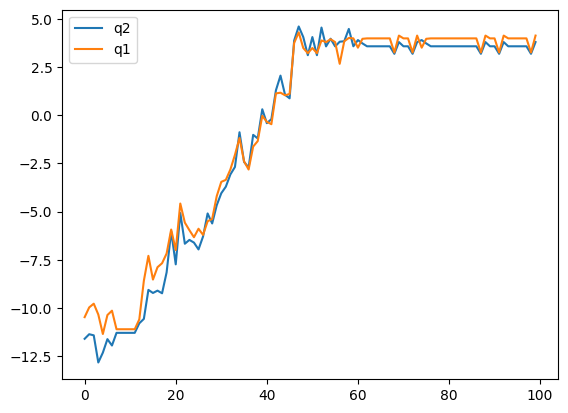

In [17]:
q1, q2 = agent.network.select('critic')(traj_states, traj_goals, traj_actions)

plt.plot(jnp.log(q2), label='q2')
plt.plot(jnp.log(q1), label='q1')
plt.legend()
plt.show()

In [18]:
all_actions = jnp.tile(jnp.arange(6), (traj_states.shape[0], 1))  # B x 6
qs = jax.lax.stop_gradient(
    jax.vmap(agent.network.select("critic"), in_axes=(None, None, 1))(traj_states, traj_goals, all_actions)
)  # 6 x 2 x B
qs = qs.min(axis=1)  # 6 x B
qs = qs.transpose(1, 0)  # B x 6
qs = value_transform(qs)

qs.shape


(100, 6)

In [19]:
dist = distrax.Categorical(logits=qs / jnp.maximum(1e-6, 1))
dist.entropy().shape

(100,)

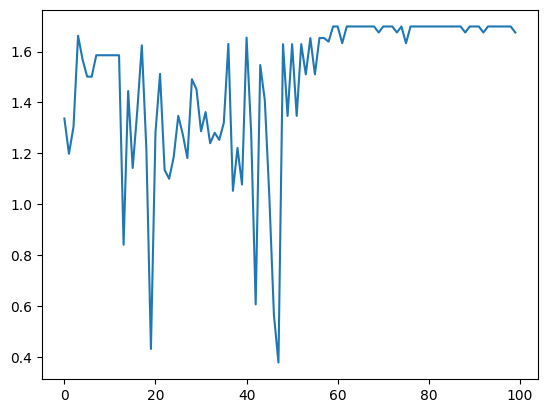

In [20]:
plt.plot(list(range(qs.shape[0])), dist.entropy(), label='entropy')

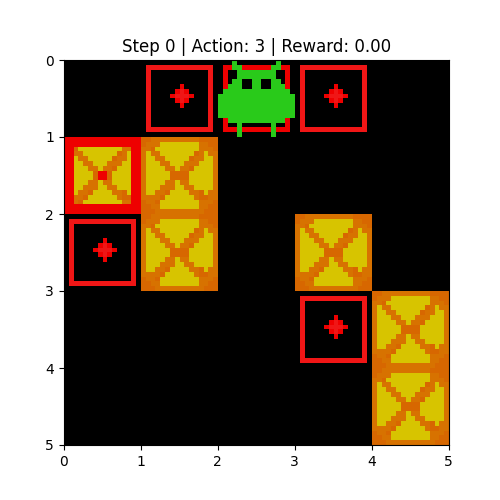

In [21]:
import IPython.display as display

grid_size = state.grid.shape[-2:]
fig, ax = plt.subplots(figsize=grid_size)

animate = functools.partial(env.animate, ax, jax.tree_util.tree_map(lambda x: x.swapaxes(1, 0), timesteps), img_prefix=os.path.join(ROOT_DIR, 'assets'))

# Create animation
anim = animation.FuncAnimation(fig, animate, frames=EPISODE_LENGTH, interval=80, repeat=False)

# Save as GIF
gif_path = f"/tmp/block_moving_epoch.gif"
anim.save(gif_path, writer='pillow')
plt.close()


# Visualize the GIF in the notebook
display.display(display.Image(filename=gif_path))


# Entropy for different checkpoints

In [22]:
timesteps_tr.grid.shape

(100, 1024, 5, 5)

In [23]:
timesteps.grid[0,0]

Array([[ 0, 10,  2,  0,  0],
       [ 2,  1,  1,  0,  0],
       [ 6,  0,  0,  0,  0],
       [ 2,  0,  1,  2,  0],
       [ 0,  0,  0,  1,  1]], dtype=int8)

In [24]:
timesteps_for_goal = jax.tree_util.tree_map(lambda x: x[0,0], timesteps)

In [25]:
actual_goal = create_solved_state(timesteps_for_goal).grid
actual_goal

Array([[ 0, 10, 10,  0,  0],
       [10,  0,  0,  0,  0],
       [ 8,  0,  0,  0,  0],
       [10,  0,  0, 10,  0],
       [ 0,  0,  0,  0,  0]], dtype=int8)

In [26]:
goal = jnp.tile(actual_goal, (100, 1,1))  # Repeat the goal for each state in the trajectory
print(goal.shape)
goal[1]

(100, 5, 5)


Array([[ 0, 10, 10,  0,  0],
       [10,  0,  0,  0,  0],
       [ 8,  0,  0,  0,  0],
       [10,  0,  0, 10,  0],
       [ 0,  0,  0,  0,  0]], dtype=int8)

In [27]:
goal = goal.reshape(goal.shape[0], -1)  # Flatten the goal for each state
goal.shape
goal = GridStatesEnum.remove_targets(goal)
goal[0]

Array([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0], dtype=int8)

Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_0.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_20.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_40.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_60.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_80.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/lon

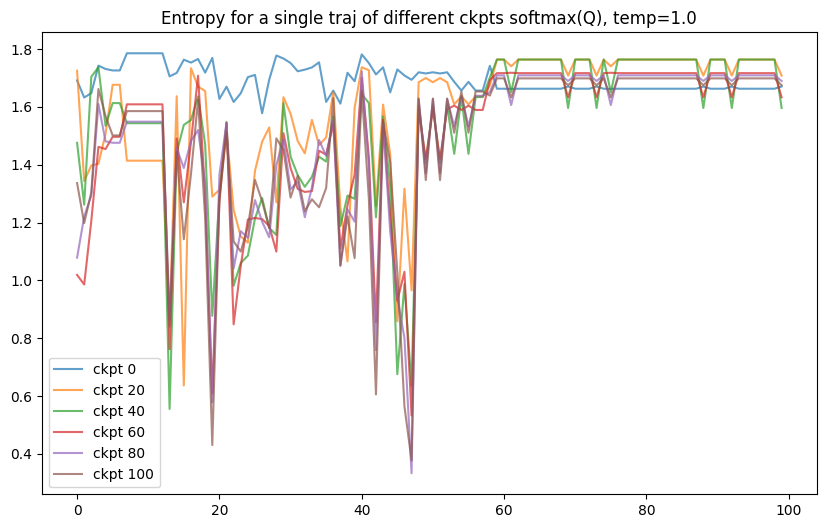

In [28]:
plt.figure(figsize=(10, 6))
for ckpt in range(0,101,20):
    agent, config = restore_agent(example_batch, MODEL_PATH, ckpt)

    all_actions = jnp.tile(jnp.arange(6), (traj_states.shape[0], 1))  # B x 6
    qs = jax.lax.stop_gradient(
        jax.vmap(agent.network.select("critic"), in_axes=(None, None, 1))(traj_states, goal, all_actions)
    )  # 6 x 2 x B
    qs = qs.min(axis=1)  # 6 x B
    qs = qs.transpose(1, 0)  # B x 6
    qs = value_transform(qs)
    dist = distrax.Categorical(logits=qs / jnp.maximum(1e-6, 1))
    plt.plot(list(range(qs.shape[0])), dist.entropy(), label=f'ckpt {ckpt}', alpha=0.7)

plt.title("Entropy for a single traj of different ckpts softmax(Q), temp=1.0")
plt.legend()
plt.show()

Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_0.pkl


2025-08-19 18:29:46.427252: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_20.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_40.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_60.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_80.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_100.pkl


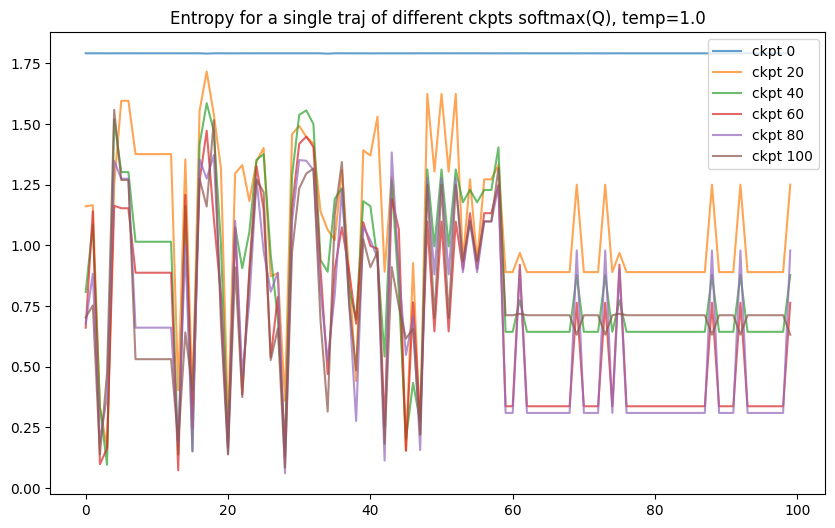

In [29]:
plt.figure(figsize=(10, 6))
for ckpt in range(0,101,20):
    agent, config = restore_agent(example_batch, MODEL_PATH, ckpt)

    dist = agent.network.select('actor')(traj_states, goal, params=None)
    plt.plot(list(range(qs.shape[0])), dist.entropy(), label=f'ckpt {ckpt}', alpha=0.7)

plt.title("Entropy for a single traj of different ckpts softmax(Q), temp=1.0")
plt.legend()
plt.show()

Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_0.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_20.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_40.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_60.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_80.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/lon

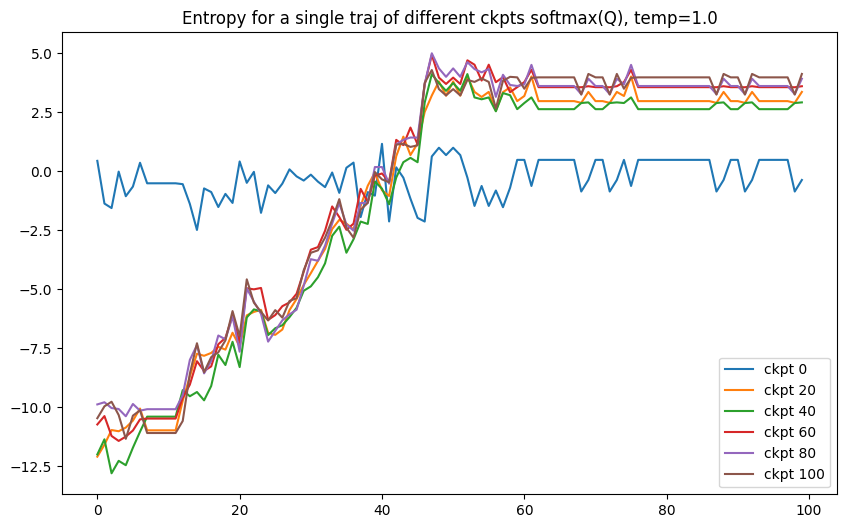

In [30]:
plt.figure(figsize=(10, 6))
for ckpt in range(0,101,20):
    agent, config = restore_agent(example_batch, MODEL_PATH, ckpt)

    q1, q2 = agent.network.select('critic')(traj_states, traj_goals, traj_actions)

    plt.plot(jnp.log(q1), label=f'ckpt {ckpt}')

plt.title("Entropy for a single traj of different ckpts softmax(Q), temp=1.0")
plt.legend()
plt.show()

Check how q changes across training

In [34]:
q_ckpts = []

for ckpt in range(0,101,10):
    agent, config = restore_agent(example_batch, MODEL_PATH, ckpt)

    all_actions = jnp.tile(jnp.arange(6), (traj_states.shape[0], 1))  # B x 6
    qs = jax.lax.stop_gradient(
        jax.vmap(agent.network.select("critic"), in_axes=(None, None, 1))(traj_states, goal, all_actions)
    )  # 6 x 2 x B
    qs = qs.min(axis=1)  # 6 x B
    qs = qs.transpose(1, 0)  # B x 6
    q_ckpts.append(qs)
q_ckpts = np.array(q_ckpts)
q_ckpts.shape

Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_0.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_10.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_20.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_30.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_40.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/lon

(11, 100, 6)

/tmp/ipykernel_142325/2971518305.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(q_ckpts.reshape(q_ckpts.shape[0], -1).T, labels=[f'ckpt {i}' for i in range(0, 101, 10)])


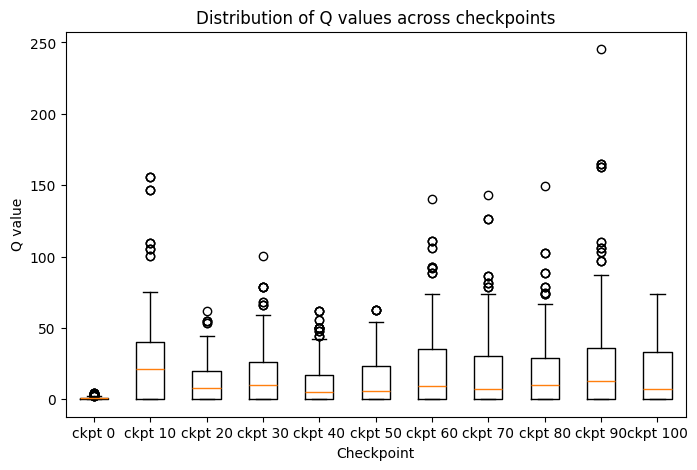

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.boxplot(q_ckpts.reshape(q_ckpts.shape[0], -1).T, labels=[f'ckpt {i}' for i in range(0, 101, 10)])
plt.xlabel('Checkpoint')
plt.ylabel('Q value')
plt.title('Distribution of Q values across checkpoints')
plt.show()

/tmp/ipykernel_142325/3113356498.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(q_ckpts_log.reshape(q_ckpts_log.shape[0], -1).T, labels=[f'ckpt {i}' for i in range(0, 101, 10)])


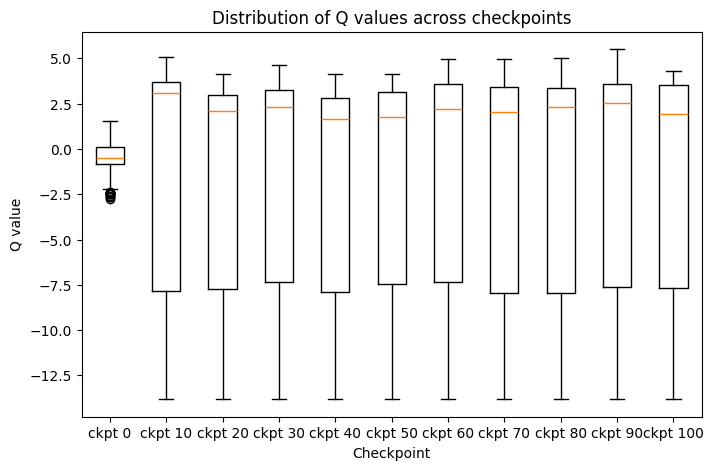

In [36]:
q_ckpts_log = value_transform(q_ckpts)
plt.figure(figsize=(8, 5))
plt.boxplot(q_ckpts_log.reshape(q_ckpts_log.shape[0], -1).T, labels=[f'ckpt {i}' for i in range(0, 101, 10)])
plt.xlabel('Checkpoint')
plt.ylabel('Q value')
plt.title('Distribution of Q values across checkpoints')
plt.show()

# Action -1 investigation

In [47]:
config = Config(
    exp=ExpConfig(seed=0, name="test"),
    env=BoxPushingConfig(
        grid_size=5,
        number_of_boxes_min=1,
        number_of_boxes_max=1,
        number_of_moving_boxes_max=1
    )
)

# %%
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))
partial_flatten = functools.partial(flatten_batch, get_next_obs=config.agent.use_next_obs)
jitted_flatten_batch = jax.jit(jax.vmap(partial_flatten, in_axes=(None, 0, 0)), static_argnums=(0,))
dummy_timestep = env.get_dummy_timestep(key)

In [48]:
replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.exp.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

example_batch = {
    'observations':dummy_timestep.grid.reshape(1, -1),  # Add batch dimension 
    'next_observations': dummy_timestep.grid.reshape(1, -1),
    'actions': jnp.ones((1,), dtype=jnp.int8) * (env._env.action_space-1), # TODO: make sure it should be the maximal value of action space  # Single action for batch size 1
    'rewards': dummy_timestep.reward.reshape(1, -1),
    'masks': 1.0 - dummy_timestep.reward.reshape(1, -1), 
    'value_goals': dummy_timestep.grid.reshape(1, -1),
    'actor_goals': dummy_timestep.grid.reshape(1, -1),
}

# %%
agent, config = restore_agent(example_batch, MODEL_PATH, CHECKPOINT)

# %%
keys = random.split(random.PRNGKey(0), NUM_ENVS)
state, info = env.reset(keys)

# %%
dummy_timestep = env.get_dummy_timestep(key)

replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.exp.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

# %%
data_key = random.PRNGKey(0)
_, _, timesteps = collect_data(agent, data_key, env, config.exp.num_envs, config.env.episode_length, use_targets=config.exp.use_targets)
buffer_state = replay_buffer.insert(buffer_state, timesteps)


Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_100.pkl


In [49]:
use_targets = False


timesteps_tr = jax.lax.cond(
    use_targets,
    lambda: timesteps.replace(),
    lambda: timesteps.replace(
        grid=GridStatesEnum.remove_targets(timesteps.grid),
        goal=GridStatesEnum.remove_targets(timesteps.goal)
    )
)

tr_states = timesteps_tr.grid
tr_actions = timesteps_tr.action
tr_goals = timesteps_tr.goal

In [50]:
tr_states.shape

(100, 1024, 5, 5)

In [51]:
idx = 0
traj_states, traj_goals, traj_actions = tr_states[:,idx], tr_goals[:,idx], tr_actions[:,idx]
traj_states.shape

(100, 5, 5)

In [52]:
traj_states, traj_goals, traj_actions = traj_states.reshape(traj_states.shape[0], -1), traj_goals.reshape(traj_goals.shape[0], -1), traj_actions.reshape(traj_actions.shape[0])
traj_states.shape, traj_goals.shape, traj_actions.shape

((100, 25), (100, 25), (100,))

In [53]:
traj_states[0].reshape(5,5)

Array([[0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=int8)

In [57]:
q1, q2 = agent.network.select('critic')(traj_states, traj_goals, traj_actions)

q1.mean(), q2.mean()

(Array(inf, dtype=float32), Array(inf, dtype=float32))

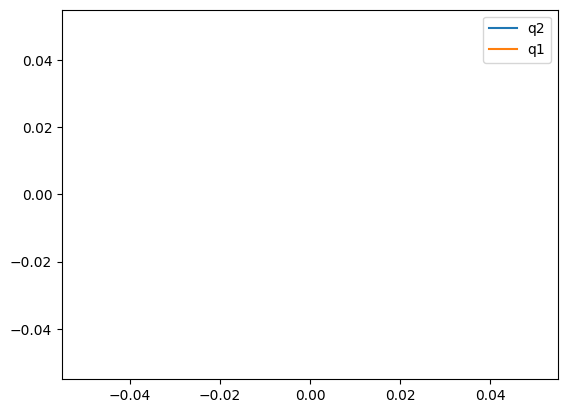

In [58]:
plt.plot(jnp.log(q2), label='q2')
plt.plot(jnp.log(q1), label='q1')
plt.legend()
plt.show()

In [59]:
q2

Array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf], dtype=float32)

Other

In [60]:
timesteps_for_goal = jax.tree_util.tree_map(lambda x: x[0,0], timesteps)
actual_goal = create_solved_state(timesteps_for_goal).grid
actual_goal
goal = jnp.tile(actual_goal, (100, 1,1))  # Repeat the goal for each state in the trajectory
print(goal.shape)
goal[1]
goal = goal.reshape(goal.shape[0], -1)  # Flatten the goal for each state
goal.shape
goal = GridStatesEnum.remove_targets(goal)
goal[0]

(100, 5, 5)


Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0], dtype=int8)

In [61]:
all_actions = jnp.tile(jnp.arange(6), (traj_states.shape[0], 1))  # B x 6
qs = jax.lax.stop_gradient(
    jax.vmap(agent.network.select("critic"), in_axes=(None, None, 1))(traj_states, goal, all_actions)
)  # 6 x 2 x B
qs = qs.min(axis=1)  # 6 x B
qs = qs.transpose(1, 0)  # B x 6
qs = value_transform(qs)
dist = distrax.Categorical(logits=qs / jnp.maximum(1e-6, 1))

In [66]:
actions = dist.sample(seed=key)
actions

Array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],      dtype=int32)

Check q for different envs

In [70]:
q_means = []
for boxes in range(1, 9):
    config = Config(
        exp=ExpConfig(seed=0, name="test"),
        env=BoxPushingConfig(
            grid_size=5,
            number_of_boxes_min=boxes,
            number_of_boxes_max=boxes,
            number_of_moving_boxes_max=boxes
        )
    )

    # %%
    env = create_env(config.env)
    env = AutoResetWrapper(env)
    key = random.PRNGKey(config.exp.seed)
    env.step = jax.jit(jax.vmap(env.step))
    env.reset = jax.jit(jax.vmap(env.reset))
    partial_flatten = functools.partial(flatten_batch, get_next_obs=config.agent.use_next_obs)
    jitted_flatten_batch = jax.jit(jax.vmap(partial_flatten, in_axes=(None, 0, 0)), static_argnums=(0,))
    dummy_timestep = env.get_dummy_timestep(key)
    replay_buffer = jit_wrap(
        TrajectoryUniformSamplingQueue(
            max_replay_size=config.exp.max_replay_size,
            dummy_data_sample=dummy_timestep,
            sample_batch_size=config.exp.batch_size,
            num_envs=config.exp.num_envs,
            episode_length=config.env.episode_length,
        )
    )
    buffer_state = jax.jit(replay_buffer.init)(key)

    example_batch = {
        'observations':dummy_timestep.grid.reshape(1, -1),  # Add batch dimension 
        'next_observations': dummy_timestep.grid.reshape(1, -1),
        'actions': jnp.ones((1,), dtype=jnp.int8) * (env._env.action_space-1), # TODO: make sure it should be the maximal value of action space  # Single action for batch size 1
        'rewards': dummy_timestep.reward.reshape(1, -1),
        'masks': 1.0 - dummy_timestep.reward.reshape(1, -1), 
        'value_goals': dummy_timestep.grid.reshape(1, -1),
        'actor_goals': dummy_timestep.grid.reshape(1, -1),
    }

    # %%
    agent, config = restore_agent(example_batch, MODEL_PATH, CHECKPOINT)

    # %%
    keys = random.split(random.PRNGKey(0), NUM_ENVS)
    state, info = env.reset(keys)

    # %%
    dummy_timestep = env.get_dummy_timestep(key)

    replay_buffer = jit_wrap(
        TrajectoryUniformSamplingQueue(
            max_replay_size=config.exp.max_replay_size,
            dummy_data_sample=dummy_timestep,
            sample_batch_size=config.exp.batch_size,
            num_envs=config.exp.num_envs,
            episode_length=config.env.episode_length,
        )
    )
    buffer_state = jax.jit(replay_buffer.init)(key)

    # %%
    data_key = random.PRNGKey(0)
    _, _, timesteps = collect_data(agent, data_key, env, config.exp.num_envs, config.env.episode_length, use_targets=config.exp.use_targets)
    buffer_state = replay_buffer.insert(buffer_state, timesteps)

    use_targets = False


    timesteps_tr = jax.lax.cond(
        use_targets,
        lambda: timesteps.replace(),
        lambda: timesteps.replace(
            grid=GridStatesEnum.remove_targets(timesteps.grid),
            goal=GridStatesEnum.remove_targets(timesteps.goal)
        )
    )

    tr_states = timesteps_tr.grid
    tr_actions = timesteps_tr.action
    tr_goals = timesteps_tr.goal
    tr_states.shape
    idx = 0
    traj_states, traj_goals, traj_actions = tr_states[:,idx], tr_goals[:,idx], tr_actions[:,idx]
    traj_states.shape
    traj_states, traj_goals, traj_actions = traj_states.reshape(traj_states.shape[0], -1), traj_goals.reshape(traj_goals.shape[0], -1), traj_actions.reshape(traj_actions.shape[0])
    traj_states.shape, traj_goals.shape, traj_actions.shape
    traj_states[0].reshape(5,5)
    q1, q2 = agent.network.select('critic')(traj_states, traj_goals, traj_actions)

    print(f"Boxes: {boxes}, Q means: {q1.mean()}, {q2.mean()}")
    q_means.append([q1.mean(), q2.mean()])

Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_100.pkl
Boxes: 1, Q means: inf, inf
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_100.pkl
Boxes: 2, Q means: 3.288085149587415e+24, 408505.65625
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_100.pkl
Boxes: 3, Q means: 61.412147521972656, 125.11227416992188
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_100.pkl
Boxes: 4, Q means: 12.590693473815918, 10.782907485961914
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc

In [72]:
q_means = np.array(q_means)

In [77]:
for boxes, q_mean in enumerate(q_means.mean(axis=1), start=1):
    print(f"boxes: {boxes}, q_mean: {q_mean:.2f}")

boxes: 1, q_mean: inf
boxes: 2, q_mean: 1644042574793707423268864.00
boxes: 3, q_mean: 93.26
boxes: 4, q_mean: 11.69
boxes: 5, q_mean: 11.67
boxes: 6, q_mean: 20.05
boxes: 7, q_mean: 9252.52
boxes: 8, q_mean: 208880065084129280.00


In [78]:
q_ckpts = []

for ckpt in range(0,101,20):
    agent, config = restore_agent(example_batch, MODEL_PATH, ckpt)

    all_actions = jnp.tile(jnp.arange(6), (traj_states.shape[0], 1))  # B x 6
    qs = jax.lax.stop_gradient(
        jax.vmap(agent.network.select("critic"), in_axes=(None, None, 1))(traj_states, goal, all_actions)
    )  # 6 x 2 x B
    qs = qs.min(axis=1)  # 6 x B
    qs = qs.transpose(1, 0)  # B x 6
    q_ckpts.append(qs)


Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_0.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_20.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_40.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_60.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/long_unbugged_check_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_80.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250814_235903/runs/lon

In [80]:
q_ckpts = np.array(q_ckpts)
q_ckpts.shape

(6, 100, 6)

In [83]:
q_ckpts.mean(axis=(1,2))

array([0.555692, 0.      , 0.      , 0.      , 0.      , 0.      ],
      dtype=float32)